## Code and methods for data preprocessing.

Topics:

1. Finding and removing outliers in the data.
2. Finding and removing gaps in the data.
3. Resampling the data.

In [1]:
# Important necessary libraries

from typing import List, Tuple
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy import signal
import warnings
import os
import seaborn as sns

#ignore warnings for the notebook
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Set your working directory [Do not forget to make a short-cut of the folder shared by Galina to your Drive]
os.chdir('/content/drive/MyDrive/#WaterSoftHack25 - Water quality project/Project Codes/input datafiles/')

# Load data

In [ ]:
# read data as a dataframe

df = pd.read_csv('11447650_cleaned_daily_data_plus_precip_turb_short.csv')

df.head()

,DATE,SSC_mg_L,SSD_st_d,Discharge_cfs,Precip_in,Turb_fnu
0,2009-12-03,25.0,562.0,8440.0,0.00,4.225000
1,2009-12-04,20.0,478.0,8650.0,0.00,4.405208
2,2009-12-05,14.0,334.0,8520.0,0.00,4.281053
3,2009-12-06,11.0,242.0,8250.0,0.13,4.666667
4,2009-12-07,21.0,507.0,9190.0,0.42,4.757317


## Finding Errors in the Data

In our case, we only selected data with an 'A' approval mark, so there is a low chance of finding any errors. Nevertheless, we will review how to identify errors if they exist.

We can use the `describe()` method to view basic statistics such as minimum value, maximum value, median, and the 1st and 3rd quartiles. Generally, errors have values that are either extremely high, extremely low, or negative.  
These can be identified using this method.

**If errors are found in the data, we simply remove them and then continue with the rest of the preprocessing methods.**

In [ ]:
df.describe()

,SSC_mg_L,SSD_st_d,Discharge_cfs,Precip_in,Turb_fnu
count,5048.000000,5048.000000,5048.000000,5048.000000,4892.000000
mean,30.222266,2624.041403,19493.597464,0.047401,13.543035
std,38.850872,5508.995356,16595.692451,0.201275,22.947697
min,1.000000,20.000000,4340.000000,0.000000,0.553125
25%,10.000000,269.000000,9200.000000,0.000000,4.117188
50%,17.000000,667.000000,14000.000000,0.000000,6.652083
75%,34.000000,1860.000000,20100.000000,0.000000,12.602083
max,582.000000,52900.000000,96200.000000,5.410000,450.437500


## Finding Gaps in the Data

Generally, two types of gaps can be found in time series data:

1. Since hourly data is recorded at 15-minute intervals, there is a chance that an entire row might be missing, resulting in gaps in the time sequence itself.
2. The second type occurs when the timestamp is present, but the gauge height is missing.


In [ ]:
def find_missing_dates(df: pd.DataFrame, date_col: str = 'DATE',
                       threshold: datetime.timedelta = datetime.timedelta(days=1)) -> Tuple[datetime.timedelta, datetime.timedelta]:
    """
    Find gaps in the date column of a DataFrame.

    Args:
    df (pd.DataFrame): Input DataFrame.
    date_col (str): Name of the date column.
    threshold (datetime.timedelta): Threshold for considering a gap.

    Returns:
    Tuple[datetime.timedelta, datetime.timedelta]: Maximum gap and total gap.
    """

    # convert the DATE column to datetime datatype - originally string
    df[date_col] = pd.to_datetime(df[date_col])

    # sort values in ascending order by DATE column
    df = df.sort_values(by=date_col)

    prev = df[date_col].iloc[0]

    total_gap = datetime.timedelta(minutes=0)
    max_diff = threshold

    print_gaps = 28
    total_gaps = 0

    print(f'Printing first {print_gaps} gaps...\n')
    for d in df[date_col].iloc[1:]:
        diff = d - prev
        if diff > max_diff:
            max_diff = diff
        if diff > threshold:
            total_gap += diff
            if print_gaps > 0:
                print(f"Gap found between {prev} and {d}: Gap: {diff}")
            print_gaps -= 1
            total_gaps += 1
        prev = d

    print(f'\nTotal number of gaps: {total_gaps}')
    print(f'Max gap: {max_diff}')
    print(f'Total gap: {total_gap}')
    return max_diff, total_gap


find_missing_dates(df)

Printing first 28 gaps...


Total number of gaps: 0
Max gap: 1 day, 0:00:00
Total gap: 0:00:00


(datetime.timedelta(days=1), datetime.timedelta(0))

## Missing Values

In [ ]:
for column in df.columns:
    missing_count = df[column].isnull().sum()
    percentage_missing = (missing_count / len(df)) * 100
    print(f'Column: {column}, Percentage of missing values: {percentage_missing:.2f} %')


Column: DATE, Percentage of missing values: 0.00 %
Column: SSC_mg_L, Percentage of missing values: 0.02 %
Column: SSD_st_d, Percentage of missing values: 0.02 %
Column: Discharge_cfs, Percentage of missing values: 0.02 %
Column: Precip_in, Percentage of missing values: 0.02 %
Column: Turb_fnu, Percentage of missing values: 3.11 %


Usually, less than 5% missing values is acceptable in a dataset.  
The size of gaps also matters, as larger gaps are generally less favorable.

## Examine the size of gaps in our data.

In [ ]:
import math

variables = ['SSC_mg_L', 'SSD_st_d', 'Discharge_cfs', 'Precip_in', 'Turb_fnu']

for var in variables:
    gap_sizes = []
    gap_dates = []
    gap_size = 0
    gap_start_date = None

    print(f'\n--- {var} ---')

    for index, row in df.iterrows():
        if pd.isna(row[var]):
            if gap_size == 0:
                gap_start_date = row['DATE']
            gap_size += 1
        else:
            if gap_size > 0:
                gap_sizes.append(gap_size)
                gap_dates.append((gap_start_date, row['DATE'])) # Store start and end dates of the gap
                gap_size = 0
                gap_start_date = None

    # Append final gap if data ends with missing values
    if gap_size > 0:
        gap_sizes.append(gap_size)
        gap_dates.append((gap_start_date, df['DATE'].iloc[-1]))

    sorted_gaps = sorted(zip(gap_sizes, gap_dates), reverse=True)

    print(f'Top 15 gaps (in rows and dates):')
    for size, dates in sorted_gaps[:15]:
        print(f"Size: {size}, Dates: {dates}")

    print(f'Total number of gaps: {len(gap_sizes)}')
    print(f'Max gap size: {max(gap_sizes) if gap_sizes else 0}')


--- SSC_mg_L ---
Top 15 gaps (in rows and dates):
Size: 1, Dates: (Timestamp('2022-09-30 00:00:00'), Timestamp('2022-10-01 00:00:00'))
Total number of gaps: 1
Max gap size: 1

--- SSD_st_d ---
Top 15 gaps (in rows and dates):
Size: 1, Dates: (Timestamp('2022-09-30 00:00:00'), Timestamp('2022-10-01 00:00:00'))
Total number of gaps: 1
Max gap size: 1

--- Discharge_cfs ---
Top 15 gaps (in rows and dates):
Size: 1, Dates: (Timestamp('2022-09-30 00:00:00'), Timestamp('2022-10-01 00:00:00'))
Total number of gaps: 1
Max gap size: 1

--- Precip_in ---
Top 15 gaps (in rows and dates):
Size: 1, Dates: (Timestamp('2022-09-30 00:00:00'), Timestamp('2022-10-01 00:00:00'))
Total number of gaps: 1
Max gap size: 1

--- Turb_fnu ---
Top 15 gaps (in rows and dates):
Size: 26, Dates: (Timestamp('2011-12-01 00:00:00'), Timestamp('2011-12-27 00:00:00'))
Size: 12, Dates: (Timestamp('2010-09-02 00:00:00'), Timestamp('2010-09-14 00:00:00'))
Size: 11, Dates: (Timestamp('2015-10-02 00:00:00'), Timestamp('2015

## Linear interpolation for missing data
We can proceed with linear interpolation since the percentage of gaps is very low relative to the overall data size. Thus, any data errors introduced will have a negligible impact on the model.

In [ ]:
def fill_missing_values(data: pd.DataFrame, method='linear') -> pd.DataFrame:
    """
    Process data: interpolate missing values with linear interpolation.

    Args:
    data (pd.DataFrame): Input DataFrame with data and 'DATE' column, which will be used as index.

    Returns:
    pd.DataFrame: Processed DataFrame.
    """
    data.set_index('DATE', inplace=True)
    data.sort_index(inplace=True)
    data = data.groupby(data.index).mean()

    for col in data.columns:
        data[col] = data[col].interpolate(method = method)

    data.reset_index(inplace=True)
    data.rename(columns={'index': 'DATE'}, inplace=True)
    return data

filled_df = fill_missing_values(df)

## Check for missing values again

In [ ]:
for column in filled_df.columns:
    missing_count = filled_df[column].isnull().sum()
    percentage_missing = (missing_count / len(filled_df)) * 100
    print(f'Column: {column}, Percentage of missing values: {percentage_missing:.2f} %')


for column in filled_df.columns:
    actual_data_points = filled_df[column].notna().sum()
    coverage_percentage = (actual_data_points / len(filled_df)) * 100
    print(f'\nColumn: {column}, Data coverage: {coverage_percentage:.2f} %')

Column: DATE, Percentage of missing values: 0.00 %
Column: SSC_mg_L, Percentage of missing values: 0.00 %
Column: SSD_st_d, Percentage of missing values: 0.00 %
Column: Discharge_cfs, Percentage of missing values: 0.00 %
Column: Precip_in, Percentage of missing values: 0.00 %
Column: Turb_fnu, Percentage of missing values: 0.00 %

Column: DATE, Data coverage: 100.00 %

Column: SSC_mg_L, Data coverage: 100.00 %

Column: SSD_st_d, Data coverage: 100.00 %

Column: Discharge_cfs, Data coverage: 100.00 %

Column: Precip_in, Data coverage: 100.00 %

Column: Turb_fnu, Data coverage: 100.00 %


## Check stats between original data and filled data

In [ ]:
# Compare lengths of dataframes
print("Original length:", len(df))
print("After filling missing dates:", len(filled_df))

Original length: 5049
After filling missing dates: 5049


In [ ]:
# Check number of non-null values for turbidity
print("Original non-null Turb_fnu:", df['Turb_fnu'].notna().sum())
print("After filling non-null Turb_fnu:", filled_df['Turb_fnu'].notna().sum())

Original non-null Turb_fnu: 4892
After filling non-null Turb_fnu: 5049


In [ ]:
print('Original data: ')
display(df.describe())
print('Filled data: ')
display(filled_df.drop(columns=['DATE']).describe())

Original data: 


,SSC_mg_L,SSD_st_d,Discharge_cfs,Precip_in,Turb_fnu
count,5048.000000,5048.000000,5048.000000,5048.000000,4892.000000
mean,30.222266,2624.041403,19493.597464,0.047401,13.543035
std,38.850872,5508.995356,16595.692451,0.201275,22.947697
min,1.000000,20.000000,4340.000000,0.000000,0.553125
25%,10.000000,269.000000,9200.000000,0.000000,4.117188
50%,17.000000,667.000000,14000.000000,0.000000,6.652083
75%,34.000000,1860.000000,20100.000000,0.000000,12.602083
max,582.000000,52900.000000,96200.000000,5.410000,450.437500


Filled data: 


,SSC_mg_L,SSD_st_d,Discharge_cfs,Precip_in,Turb_fnu
count,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000
mean,30.216974,2623.534066,19491.201228,0.047392,13.375580
std,38.848844,5508.567627,16594.922097,0.201256,22.621493
min,1.000000,20.000000,4340.000000,0.000000,0.553125
25%,10.000000,269.000000,9200.000000,0.000000,4.151042
50%,17.000000,667.000000,14000.000000,0.000000,6.671875
75%,34.000000,1860.000000,20100.000000,0.000000,12.365625
max,582.000000,52900.000000,96200.000000,5.410000,450.437500


In [ ]:
filled_df.head()

,DATE,SSC_mg_L,SSD_st_d,Discharge_cfs,Precip_in,Turb_fnu
0,2009-12-03,25.0,562.0,8440.0,0.00,4.225000
1,2009-12-04,20.0,478.0,8650.0,0.00,4.405208
2,2009-12-05,14.0,334.0,8520.0,0.00,4.281053
3,2009-12-06,11.0,242.0,8250.0,0.13,4.666667
4,2009-12-07,21.0,507.0,9190.0,0.42,4.757317


In [ ]:
filled_df.tail()

,DATE,SSC_mg_L,SSD_st_d,Discharge_cfs,Precip_in,Turb_fnu
5044,2023-09-25,16.0,806.0,18200.0,0.0,5.411458
5045,2023-09-26,15.0,698.0,17800.0,0.0,5.282292
5046,2023-09-27,13.0,619.0,17400.0,0.0,5.100000
5047,2023-09-28,13.0,582.0,17200.0,0.0,4.800000
5048,2023-09-29,12.0,559.0,17000.0,0.0,4.809375


In [ ]:
df.tail()

,SSC_mg_L,SSD_st_d,Discharge_cfs,Precip_in,Turb_fnu
DATE,,,,,
2023-09-25,16.0,806.0,18200.0,0.0,5.411458
2023-09-26,15.0,698.0,17800.0,0.0,5.282292
2023-09-27,13.0,619.0,17400.0,0.0,5.100000
2023-09-28,13.0,582.0,17200.0,0.0,4.800000
2023-09-29,12.0,559.0,17000.0,0.0,4.809375


# Plot data to check it

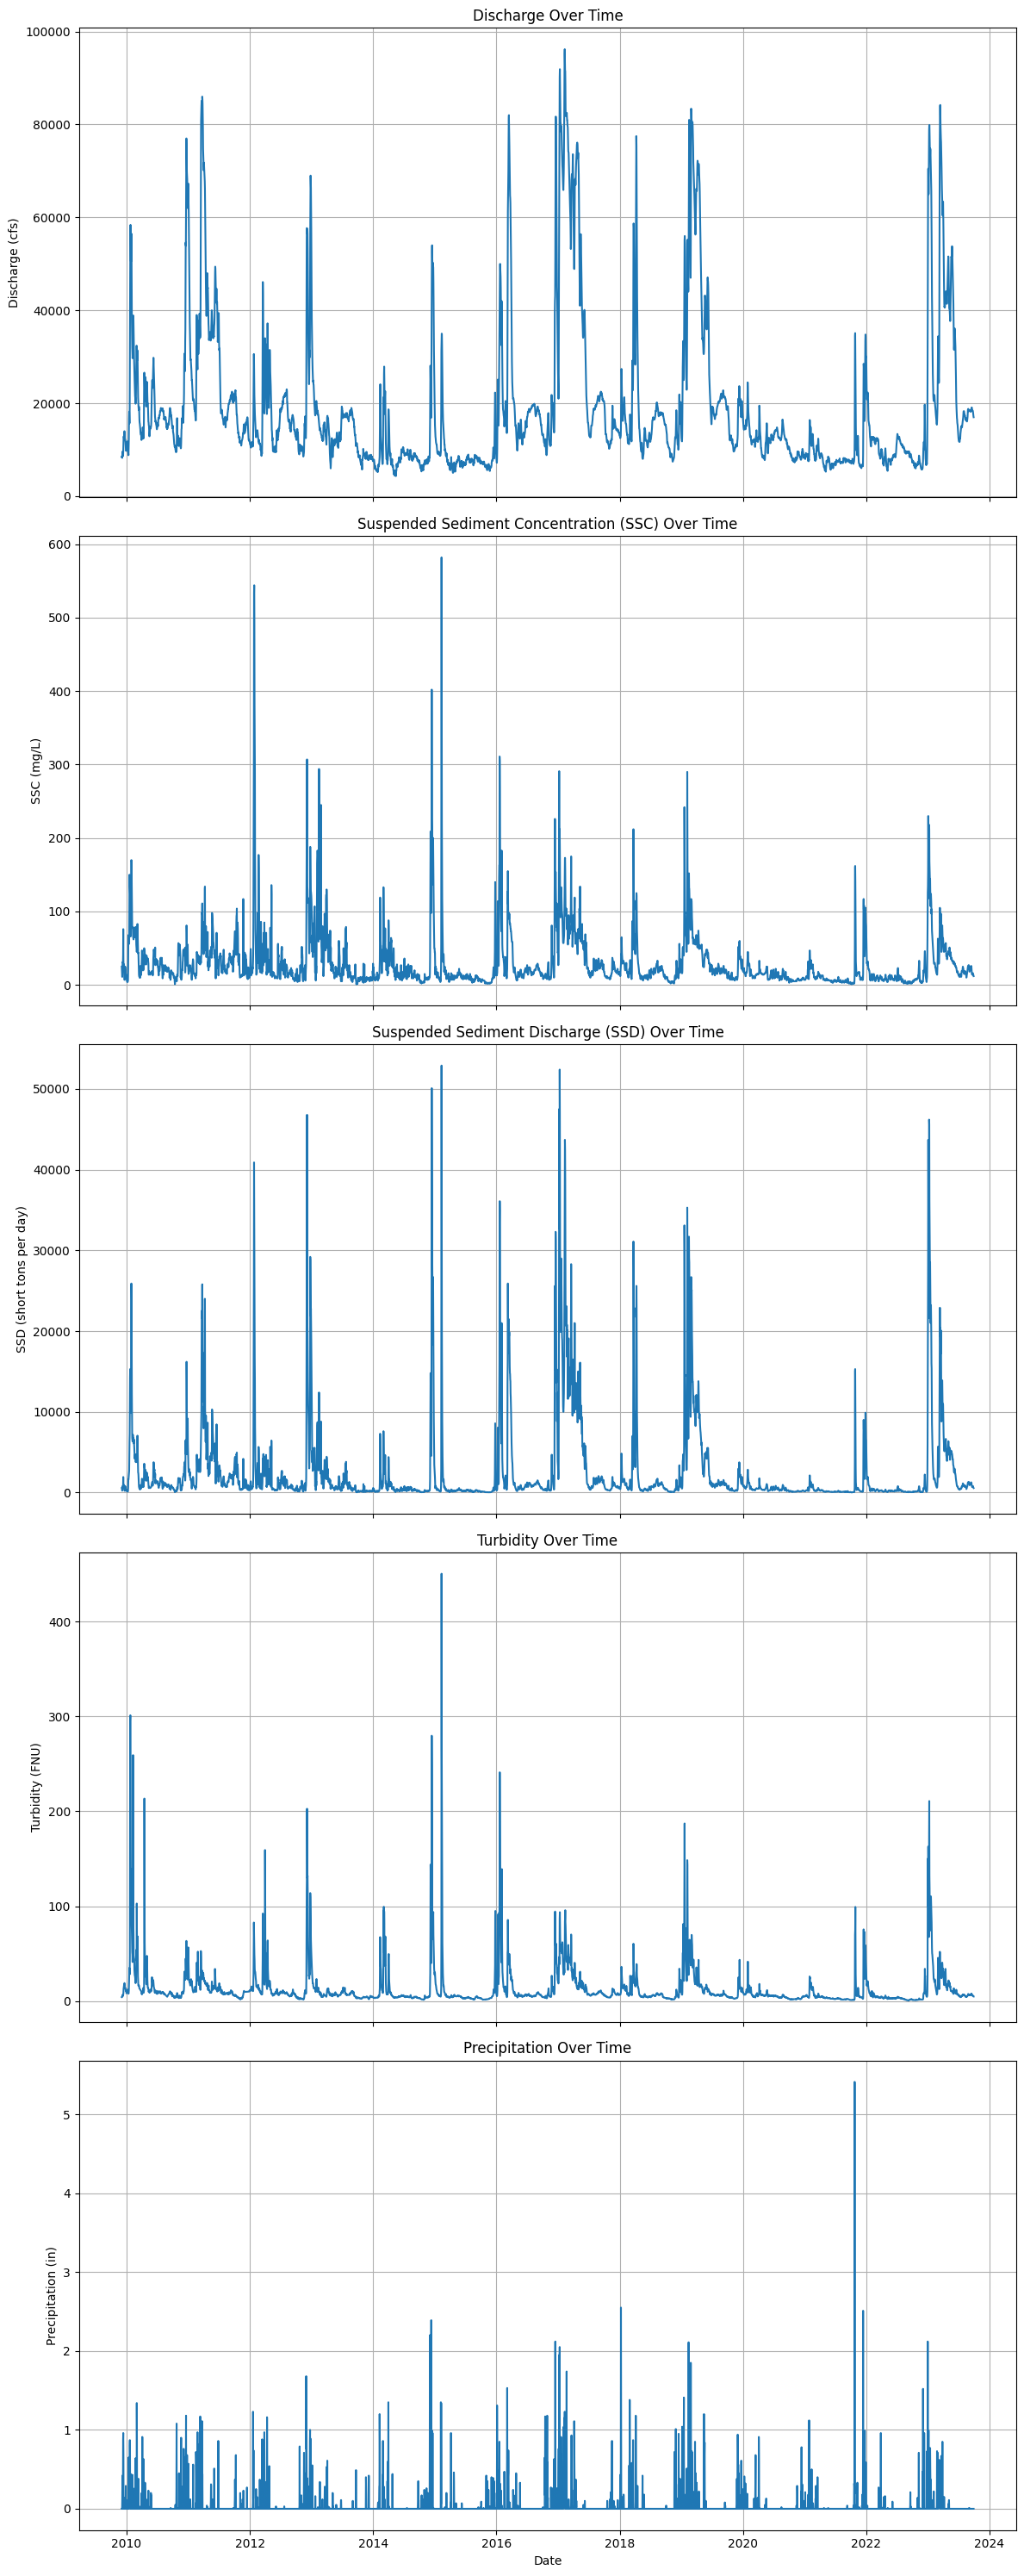

In [ ]:
# Plot time series for Discharge, SSC, SSD, turbidity, precipitation in one figure with the same x-axis range

# Ensure the DATE column is in datetime format and set as index if not already done
filled_df['DATE'] = pd.to_datetime(filled_df['DATE'])
filled_df.set_index('DATE', inplace=True)

# Create a figure with 5 subplots sharing the x-axis
fig, axes = plt.subplots(5, 1, figsize=(12, 30), sharex=True)

# Plot discharge
sns.lineplot(ax=axes[0], data=filled_df, y='Discharge_cfs', x=filled_df.index)
axes[0].set_title('Discharge Over Time')
axes[0].set_ylabel('Discharge (cfs)')
axes[0].grid(True)

# Plot SSC
sns.lineplot(ax=axes[1], data=filled_df, y='SSC_mg_L', x=filled_df.index)
axes[1].set_title('Suspended Sediment Concentration (SSC) Over Time')
axes[1].set_ylabel('SSC (mg/L)')
axes[1].grid(True)

# Plot SSD
sns.lineplot(ax=axes[2], data=filled_df, y='SSD_st_d', x=filled_df.index)
axes[2].set_title('Suspended Sediment Discharge (SSD) Over Time')
axes[2].set_ylabel('SSD (short tons per day)')
axes[2].set_xlabel('Date')
axes[2].grid(True)

# Plot Turbidity
sns.lineplot(ax=axes[3], data=filled_df, y='Turb_fnu', x=filled_df.index)
axes[3].set_title('Turbidity Over Time')
axes[3].set_ylabel('Turbidity (FNU)')
axes[3].set_xlabel('Date')
axes[3].grid(True)

# Plot Precipitation
sns.lineplot(ax=axes[4], data=filled_df, y='Precip_in', x=filled_df.index)
axes[4].set_title('Precipitation Over Time')
axes[4].set_ylabel('Precipitation (in)')
axes[4].set_xlabel('Date')
axes[4].grid(True)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Show the plot
plt.show()

# Save the data

In [ ]:
filled_df.to_csv(f"11447650_filled_daily_data.csv")

# Check correlations between parameters

In [ ]:
# read data as a dataframe

df = pd.read_csv('11447650_filled_daily_data.csv')

df.head()

,DATE,SSC_mg_L,SSD_st_d,Discharge_cfs,Precip_in,Turb_fnu
0,2009-12-03,25.0,562.0,8440.0,0.00,4.225000
1,2009-12-04,20.0,478.0,8650.0,0.00,4.405208
2,2009-12-05,14.0,334.0,8520.0,0.00,4.281053
3,2009-12-06,11.0,242.0,8250.0,0.13,4.666667
4,2009-12-07,21.0,507.0,9190.0,0.42,4.757317


# Check correlation

## --- Correlation matrix ---

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.drop(columns=['DATE']).corr()
print(correlation_matrix)


               SSC_mg_L  SSD_st_d  Discharge_cfs  Precip_in  Turb_fnu
SSC_mg_L       1.000000  0.857183       0.589934   0.154810  0.736428
SSD_st_d       0.857183  1.000000       0.816276   0.187142  0.757547
Discharge_cfs  0.589934  0.816276       1.000000   0.157664  0.567583
Precip_in      0.154810  0.187142       0.157664   1.000000  0.145373
Turb_fnu       0.736428  0.757547       0.567583   0.145373  1.000000


## --- PCA ---

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Select relevant columns
variables = ['SSD_st_d', 'Discharge_cfs', 'Precip_in', 'Turb_fnu', 'SSC_mg_L']
X = df[variables].dropna()

# Standardize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=len(variables))
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# Explained variance
explained_var = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_var)
print("Cumulative explained variance:", explained_var.cumsum())

Explained variance ratio: [0.84633748 0.09919155 0.02574228 0.01691472]
Cumulative explained variance: [0.84633748 0.94552904 0.97127132 0.98818604]


In [ ]:
# PCA loadings (correlation with original variables)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(variables))],
    index=variables
)
print("\nPCA Loadings (correlation with original variables):")
print(loadings)


PCA Loadings (correlation with original variables):
                    PC1       PC2       PC3       PC4       PC5
SSD_st_d       0.454411  0.531452 -0.004424 -0.276760 -0.659131
Discharge_cfs  0.843925 -0.513024 -0.012590  0.042225  0.150517
Precip_in      0.031925  0.042028  0.997549  0.010838  0.044649
Turb_fnu       0.162841  0.345596 -0.029954  0.923655  0.003288
SSC_mg_L       0.231872  0.577202 -0.061815 -0.261468  0.735450


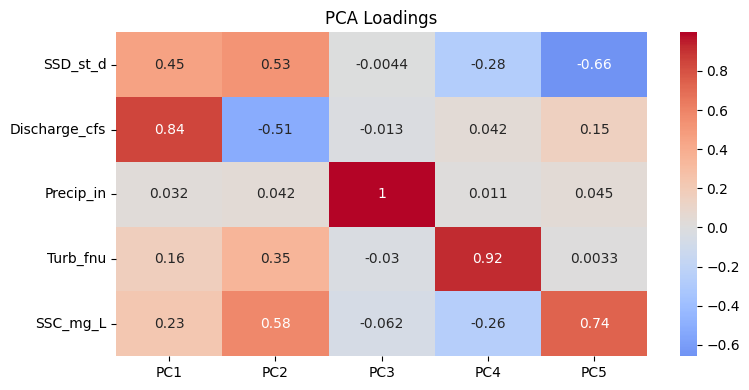

In [ ]:
# Heatmap of loadings to visualize correlation structure
plt.figure(figsize=(8, 4))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings')
plt.tight_layout()
plt.show()

# Correlation and PCA results:
Looks like precipitation doesn't have strong correaltion with other variables.
That is also confirmed with PCA: precipitation is statistically independent from the other variables.